In [1]:
import collections
import os
from six.moves import urllib
#import daft as daft
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import tensorflow_datasets as tfds
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
tfb = tfp.bijectors

warnings.simplefilter('ignore')

In [2]:
def load_and_preprocess_radon_dataset(state='MN'):  
  """Preprocess Radon dataset as done in "Bayesian Data Analysis" book.

  We filter to Minnesota data (919 examples) and preprocess to obtain the
  following features:
  - `log_uranium_ppm`: Log of soil uranium measurements.
  - `county`: Name of county in which the measurement was taken.
  - `floor`: Floor of house (0 for basement, 1 for first floor) on which the
    measurement was taken.

  The target variable is `log_radon`, the log of the Radon measurement in the
  house.
  """
  ds = tfds.load('radon', split='train')
  radon_data = tfds.as_dataframe(ds)
  radon_data.rename(lambda s: s[9:] if s.startswith('feat') else s, axis=1, inplace=True)
  df = radon_data[radon_data.state==state.encode()].copy()

  # For any missing or invalid activity readings, we'll use a value of `0.1`.
  df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)
  # Make county names look nice. 
  df['county'] = df.county.apply(lambda s: s.decode()).str.strip().str.title()
  # Remap categories to start from 0 and end at max(category).
  county_name = sorted(df.county.unique())
  df['county'] = df.county.astype(
      pd.api.types.CategoricalDtype(categories=county_name)).cat.codes
  county_name = list(map(str.strip, county_name))

  df['log_radon'] = df['radon'].apply(np.log)
  df['log_uranium_ppm'] = df['Uppm'].apply(np.log)
  df = df[['idnum', 'log_radon', 'floor', 'county', 'log_uranium_ppm']]

  return df, county_name

In [3]:
radon, county_name = load_and_preprocess_radon_dataset()
num_counties = len(county_name)
num_observations = len(radon)

In [14]:
num_counties

85

In [4]:
# Create copies of variables as Tensors.
county = tf.convert_to_tensor(radon['county'], dtype=tf.int32)
floor = tf.convert_to_tensor(radon['floor'], dtype=tf.float32)
log_radon = tf.convert_to_tensor(radon['log_radon'], dtype=tf.float32)
log_uranium = tf.convert_to_tensor(radon['log_uranium_ppm'], dtype=tf.float32)

In [5]:
radon.head()

,idnum,log_radon,floor,county,log_uranium_ppm
8,5161,1.791759,0,6,0.271614
29,5926,2.501436,0,79,-0.147484
32,5793,-0.223144,0,69,-0.474674
39,5829,1.193922,0,69,-0.474674
60,5231,1.064711,0,17,-0.633391


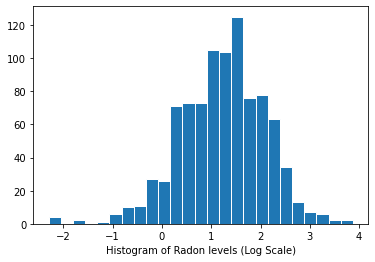

In [6]:
plt.hist(log_radon.numpy(), bins=25, edgecolor='white')
plt.xlabel("Histogram of Radon levels (Log Scale)")
plt.show()

In [10]:
@tf.function
def affine(x, kernel_diag, bias=tf.zeros([])):
  """`kernel_diag * x + bias` with broadcasting."""
  kernel_diag = tf.ones_like(x) * kernel_diag
  bias = tf.ones_like(x) * bias
  y = x * kernel_diag + bias
  print(y)
  return y

In [11]:
def pooled_model(floor):
  """Creates a joint distribution representing our generative process."""
  return tfd.JointDistributionSequential([
      tfd.Normal(loc=0., scale=1e5),  
      tfd.Normal(loc=0., scale=1e5),  
      tfd.HalfCauchy(loc=0., scale=5),  
      lambda s, b1, b0: tfd.MultivariateNormalDiag( 
          loc=affine(floor, b1[..., tf.newaxis], b0[..., tf.newaxis]),
          scale_identity_multiplier=s)
  ])


@tf.function
def pooled_log_prob(alpha, beta, sigma):
  """Computes `joint_log_prob` pinned at `log_radon`."""
  return pooled_model(floor).log_prob([alpha, beta, sigma, log_radon])

In [12]:
@tf.function
def sample_pooled(num_chains, num_results, num_burnin_steps, num_observations):
  """Samples from the pooled model."""
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=pooled_log_prob,
      num_leapfrog_steps=10,
      step_size=0.005)

  initial_state = [
      tf.zeros([num_chains], name='init_alpha'),
      tf.zeros([num_chains], name='init_beta'),
      tf.ones([num_chains], name='init_sigma')
  ]

  # Constrain `sigma` to the positive real axis. Other variables are
  # unconstrained.
  unconstraining_bijectors = [
      tfb.Identity(),  # alpha
      tfb.Identity(),  # beta
      tfb.Exp()        # sigma
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)

  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [13]:
initial_state = [
      tf.zeros([4], name='init_alpha'),
      tf.zeros([4], name='init_beta'),
      tf.ones([4], name='init_sigma')
  ]
pooled_log_prob(initial_state[0], initial_state[1],initial_state[2])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Tensor("add:0", shape=(919,), dtype=float32)
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Tensor("add:0", shape=(4, 919), dtype=float32)


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-1894.8097, -1894.8097, -1894.8097, -1894.8097], dtype=float32)>

In [26]:
PooledModel = collections.namedtuple('PooledModel', ['alpha', 'beta', 'sigma'])

samples, acceptance_probs = sample_pooled(
    num_chains=4,
    num_results=1000,
    num_burnin_steps=1000,
    num_observations=num_observations)

print('Acceptance Probabilities for each chain: ', acceptance_probs.numpy())
pooled_samples = PooledModel._make(samples)

Acceptance Probabilities for each chain:  [0.996 0.999 0.999 0.995]


In [20]:
for var, var_samples in pooled_samples._asdict().items():
  print('R-hat for ', var, ':\t',
        tfp.mcmc.potential_scale_reduction(var_samples).numpy())

R-hat for  alpha :	 1.0009041
R-hat for  beta :	 1.0026183
R-hat for  sigma :	 0.99917877


In [21]:
def reduce_samples(var_samples, reduce_fn):
  """Reduces across leading two dims using reduce_fn."""
  # Collapse the first two dimensions, typically (num_chains, num_samples), and
  # compute np.mean or np.std along the remaining axis.
  if isinstance(var_samples, tf.Tensor):
    var_samples = var_samples.numpy() # convert to numpy array
  var_samples = np.reshape(var_samples, (-1,) +  var_samples.shape[2:])
  return np.apply_along_axis(reduce_fn, axis=0, arr=var_samples)

sample_mean = lambda samples : reduce_samples(samples, np.mean)

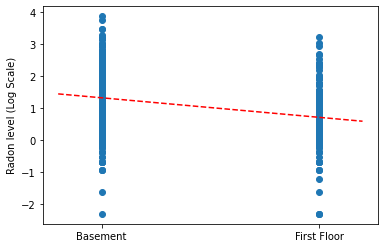

In [22]:
LinearEstimates = collections.namedtuple('LinearEstimates',
                                        ['intercept', 'slope'])

pooled_estimate = LinearEstimates(
  intercept=sample_mean(pooled_samples.alpha),
  slope=sample_mean(pooled_samples.beta)
)

plt.scatter(radon.floor, radon.log_radon)
xvals = np.linspace(-0.2, 1.2)
plt.ylabel('Radon level (Log Scale)')
plt.xticks([0, 1], ['Basement', 'First Floor'])
plt.plot(xvals, pooled_estimate.intercept + pooled_estimate.slope * xvals, 'r--')
plt.show()

In [23]:
def plot_traces(var_name, samples, num_chains):
  if isinstance(samples, tf.Tensor):
    samples = samples.numpy() # convert to numpy array
  fig, axes = plt.subplots(1, 2, figsize=(14, 1.5), sharex='col', sharey='col')
  for chain in range(num_chains):
    axes[0].plot(samples[:, chain], alpha=0.7)
    axes[0].title.set_text("'{}' trace".format(var_name))
    sns.kdeplot(samples[:, chain], ax=axes[1], shade=False)
    axes[1].title.set_text("'{}' distribution".format(var_name))
    axes[0].set_xlabel('Iteration')
    axes[1].set_xlabel(var_name)
  plt.show()

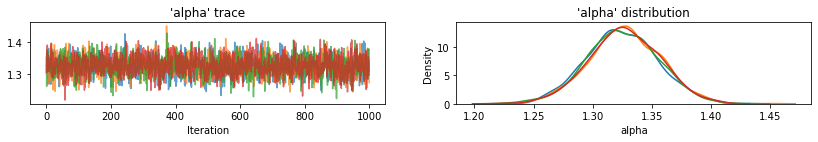

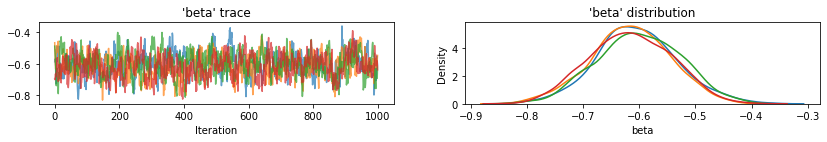

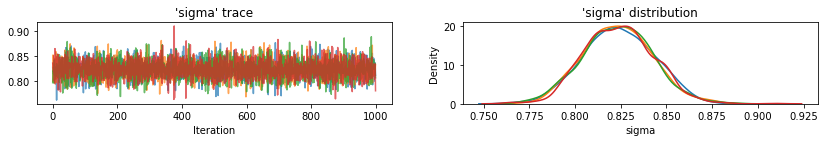

In [16]:
for var, var_samples in pooled_samples._asdict().items():
  plot_traces(var, samples=var_samples, num_chains=4)

In [29]:
def unpooled_model(floor, county):
  """Creates a joint distribution for the unpooled model."""
  return tfd.JointDistributionSequential([
      tfd.MultivariateNormalDiag(       # alpha
          loc=tf.zeros([num_counties]), scale_identity_multiplier=1e5),
      tfd.Normal(loc=0., scale=1e5),    # beta
      tfd.HalfCauchy(loc=0., scale=5),  # sigma
      lambda s, b1, b0: tfd.MultivariateNormalDiag(  # y
          loc=affine(
            floor, b1[..., tf.newaxis], tf.gather(b0, county, axis=-1)),
          scale_identity_multiplier=s)
  ])


@tf.function
def unpooled_log_prob(beta0, beta1, sigma):
  """Computes `joint_log_prob` pinned at `log_radon`."""
  return (
    unpooled_model(floor, county).log_prob([beta0, beta1, sigma, log_radon]))

In [30]:
@tf.function
def sample_unpooled(num_chains, num_results, num_burnin_steps):
  """Samples from the unpooled model."""
  # Initialize the HMC transition kernel.
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=unpooled_log_prob,
      num_leapfrog_steps=10,
      step_size=0.025)

  initial_state = [
      tf.zeros([num_chains, num_counties], name='init_beta0'),
      tf.zeros([num_chains], name='init_beta1'),
      tf.ones([num_chains], name='init_sigma')
  ]
  # Contrain `sigma` to the positive real axis. Other variables are
  # unconstrained.
  unconstraining_bijectors = [
      tfb.Identity(),  # alpha
      tfb.Identity(),  # beta
      tfb.Exp()        # sigma
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [31]:
UnpooledModel = collections.namedtuple('UnpooledModel',
                                       ['alpha', 'beta', 'sigma'])

samples, acceptance_probs = sample_unpooled(
    num_chains=4, num_results=1000, num_burnin_steps=1000)

print('Acceptance Probabilities: ', acceptance_probs.numpy())
unpooled_samples = UnpooledModel._make(samples)

print('R-hat for beta:',
      tfp.mcmc.potential_scale_reduction(unpooled_samples.beta).numpy())
print('R-hat for sigma:',
      tfp.mcmc.potential_scale_reduction(unpooled_samples.sigma).numpy())

Acceptance Probabilities:  [0.887 0.901 0.889 0.908]
R-hat for beta: 1.0095713
R-hat for sigma: 1.0015299


In [38]:
samples

[<tf.Tensor: shape=(1000, 4, 85), dtype=float32, numpy=
 array([[[1.8131682 , 0.842928  , 0.9499399 , ..., 1.7723788 ,
          1.6410505 , 2.083419  ],
         [0.8227787 , 1.0427082 , 1.2835382 , ..., 1.3719996 ,
          1.5132313 , 1.0581968 ],
         [1.0969621 , 1.0566872 , 1.9557056 , ..., 1.7007939 ,
          1.7388629 , 1.3259165 ],
         [1.105802  , 0.85292286, 1.3844656 , ..., 1.6557472 ,
          1.7370943 , 0.79839617]],
 
        [[1.7507957 , 0.8091078 , 0.9479047 , ..., 1.9618752 ,
          1.4425324 , 2.060913  ],
         [0.7754762 , 0.8261395 , 1.2115632 , ..., 1.5769114 ,
          1.5944024 , 1.5881934 ],
         [1.0660895 , 0.7205547 , 1.96339   , ..., 1.8722477 ,
          1.4389745 , 1.2720524 ],
         [0.6149364 , 0.9350208 , 1.4153837 , ..., 1.7239865 ,
          1.4083107 , 0.82349104]],
 
        [[1.8677082 , 0.7991491 , 1.1796664 , ..., 1.7688415 ,
          1.6206193 , 2.125199  ],
         [1.1602397 , 1.0583556 , 1.5182538 , ..., 1.752

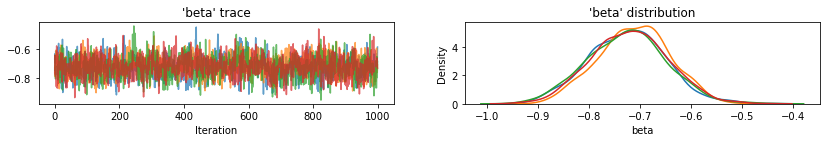

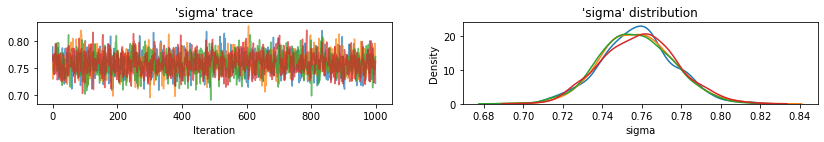

In [39]:
plot_traces(var_name='beta', samples=unpooled_samples.beta, num_chains=4)
plot_traces(var_name='sigma', samples=unpooled_samples.sigma, num_chains=4)

In [65]:
def forest_plot(num_chains, num_vars, var_name, var_labels, samples):
  fig, axes = plt.subplots(
      1, 2, figsize=(12, 15), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
  for var_idx in range(num_vars):
    values = samples[..., var_idx]
    rhat = tfp.mcmc.diagnostic.potential_scale_reduction(values).numpy()
    meds = np.median(values, axis=-2)
    los = np.percentile(values, 5, axis=-2)
    his = np.percentile(values, 95, axis=-2)

    for i in range(num_chains):
      height = 0.1 + 0.3 * var_idx + 0.05 * i
      axes[0].plot([los[i], his[i]], [height, height], 'C0-', lw=2, alpha=0.5)
      axes[0].plot([meds[i]], [height], 'C0o', ms=1.5)
    axes[1].plot([rhat], [height], 'C0o', ms=4)

  axes[0].set_yticks(np.linspace(0.15, height, num_vars))
  axes[0].set_ylim(0, 26)
  axes[0].grid(which='both')
  axes[0].invert_yaxis()
  axes[0].set_yticklabels(var_labels)
  axes[0].xaxis.set_label_position('top')
  axes[0].set(xlabel='95% Credible Intervals for {}'.format(var_name))

  axes[1].set_xticks(np.arange(.9,1.5,.05))
  axes[1].set_xlim(0.95, 1.1)
  axes[1].grid(which='both')
  axes[1].set(xlabel='R-hat')
  axes[1].xaxis.set_label_position('top')

  plt.show()

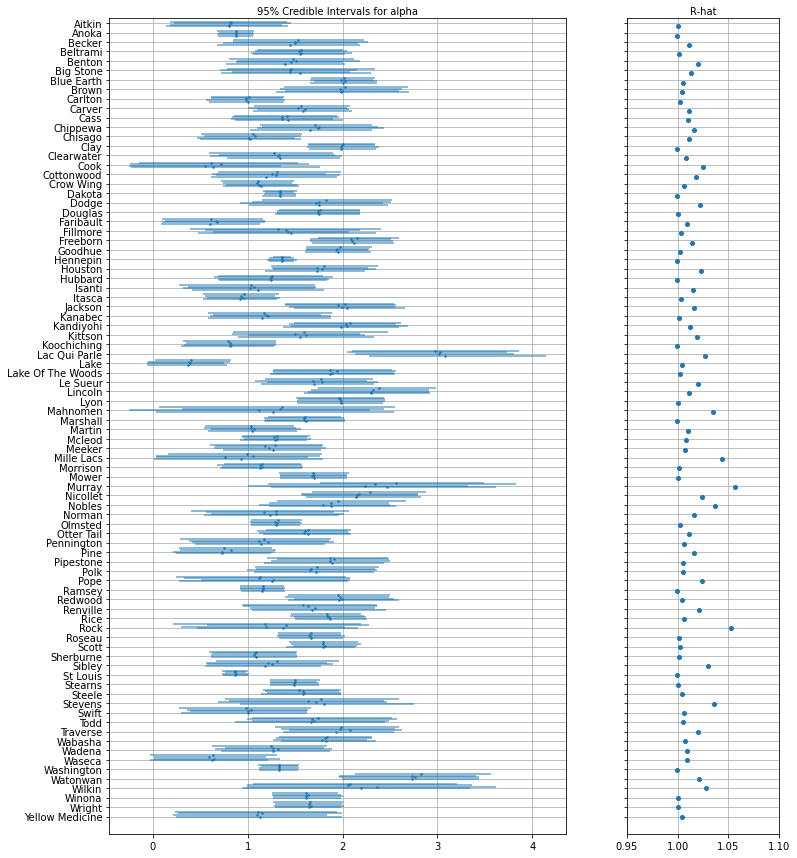

In [66]:
forest_plot(
    num_chains=4,
    num_vars=num_counties,
    var_name='alpha',
    var_labels=county_name,
    samples=unpooled_samples.alpha.numpy())

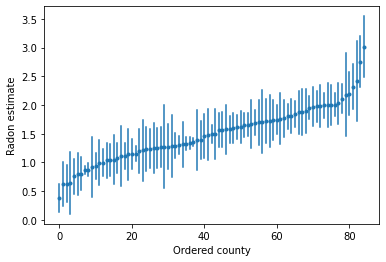

In [67]:
unpooled_intercepts = reduce_samples(unpooled_samples.alpha, np.mean)
unpooled_intercepts_se = reduce_samples(unpooled_samples.alpha, np.std)

def plot_ordered_estimates():
  means = pd.Series(unpooled_intercepts, index=county_name)
  std_errors = pd.Series(unpooled_intercepts_se, index=county_name)
  order = means.sort_values().index

  plt.plot(range(num_counties), means[order], '.')
  for i, m, se in zip(range(num_counties), means[order], std_errors[order]):
    plt.plot([i, i], [m - se, m + se], 'C0-')
  plt.xlabel('Ordered county')
  plt.ylabel('Radon estimate')
  plt.show()

plot_ordered_estimates()

In [68]:
def plot_estimates(linear_estimates, labels, sample_counties):
  fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
  axes = axes.ravel()
  intercepts_indexed = []
  slopes_indexed = []
  for intercepts, slopes in linear_estimates:
    intercepts_indexed.append(pd.Series(intercepts, index=county_name))
    slopes_indexed.append(pd.Series(slopes, index=county_name))

  markers = ['-', 'r--', 'k:']
  sample_county_codes = [county_name.index(c) for c in sample_counties]
  for i, c in enumerate(sample_county_codes):
    y = radon.log_radon[radon.county == c]
    x = radon.floor[radon.county == c]
    axes[i].scatter(
        x + np.random.randn(len(x)) * 0.01, y, alpha=0.4, label='Log Radon')

    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    for k in range(len(intercepts_indexed)):
      axes[i].plot(
          xvals,
          intercepts_indexed[k][c] + slopes_indexed[k][c] * xvals,
          markers[k],
          label=labels[k])

    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Basement', 'First Floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(sample_counties[i])
    if not i % 2:
      axes[i].set_ylabel('Log Radon level')
  axes[3].legend(bbox_to_anchor=(1.05, 0.9), borderaxespad=0.)

  plt.show()

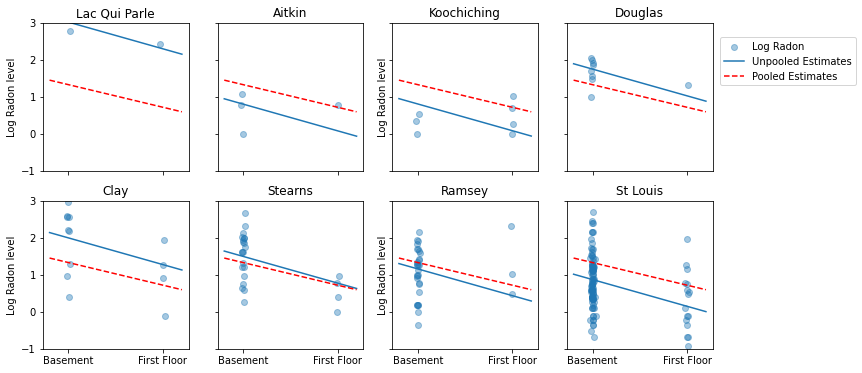

In [69]:
unpooled_estimates = LinearEstimates(
  sample_mean(unpooled_samples.alpha),
  sample_mean(unpooled_samples.beta)
)

sample_counties = ('Lac Qui Parle', 'Aitkin', 'Koochiching', 'Douglas', 'Clay',
                   'Stearns', 'Ramsey', 'St Louis')
plot_estimates(
    linear_estimates=[unpooled_estimates, pooled_estimate],
    labels=['Unpooled Estimates', 'Pooled Estimates'],
    sample_counties=sample_counties)

In [70]:
def partial_pooling_model(county):
  """Creates a joint distribution for the partial pooling model."""
  return tfd.JointDistributionSequential([
      tfd.Normal(loc=0., scale=1e5),    # mu_a
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_a
      lambda sigma_a, mu_a: tfd.MultivariateNormalDiag(  # a
          loc=mu_a[..., tf.newaxis] * tf.ones([num_counties])[tf.newaxis, ...],
          scale_identity_multiplier=sigma_a),
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_y
      lambda sigma_y, a: tfd.MultivariateNormalDiag(  # y
          loc=tf.gather(a, county, axis=-1),
          scale_identity_multiplier=sigma_y)
  ])


@tf.function
def partial_pooling_log_prob(mu_a, sigma_a, a, sigma_y):
  """Computes joint log prob pinned at `log_radon`."""
  return partial_pooling_model(county).log_prob(
      [mu_a, sigma_a, a, sigma_y, log_radon])

In [71]:
@tf.function
def sample_partial_pooling(num_chains, num_results, num_burnin_steps):
  """Samples from the partial pooling model."""
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=partial_pooling_log_prob,
      num_leapfrog_steps=10,
      step_size=0.01)

  initial_state = [
      tf.zeros([num_chains], name='init_mu_a'),
      tf.ones([num_chains], name='init_sigma_a'),
      tf.zeros([num_chains, num_counties], name='init_a'),
      tf.ones([num_chains], name='init_sigma_y')
  ]
  unconstraining_bijectors = [
      tfb.Identity(),  # mu_a
      tfb.Exp(),       # sigma_a
      tfb.Identity(),  # a
      tfb.Exp()        # sigma_y
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [72]:
PartialPoolingModel = collections.namedtuple(
    'PartialPoolingModel', ['mu_a', 'sigma_a', 'a', 'sigma_y'])

samples, acceptance_probs = sample_partial_pooling(
    num_chains=4, num_results=1000, num_burnin_steps=1000)

print('Acceptance Probabilities: ', acceptance_probs.numpy())
partial_pooling_samples = PartialPoolingModel._make(samples)

Acceptance Probabilities:  [0.989 0.988 0.987 0.989]


In [73]:
for var in ['mu_a', 'sigma_a', 'sigma_y']:
  print(
      'R-hat for ', var, '\t:',
      tfp.mcmc.potential_scale_reduction(getattr(partial_pooling_samples,
                                                 var)).numpy())

R-hat for  mu_a 	: 1.0780262
R-hat for  sigma_a 	: 1.1331758
R-hat for  sigma_y 	: 1.0019817


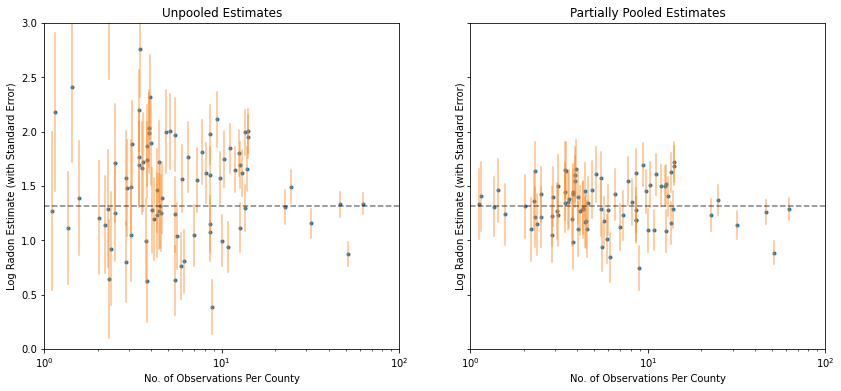

In [74]:
partial_pooling_intercepts = reduce_samples(
    partial_pooling_samples.a.numpy(), np.mean)
partial_pooling_intercepts_se = reduce_samples(
    partial_pooling_samples.a.numpy(), np.std)

def plot_unpooled_vs_partial_pooling_estimates():
  fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

  # Order counties by number of observations (and add some jitter).
  num_obs_per_county = (
      radon.groupby('county')['idnum'].count().values.astype(np.float32))
  num_obs_per_county += np.random.normal(scale=0.5, size=num_counties)

  intercepts_list = [unpooled_intercepts, partial_pooling_intercepts]
  intercepts_se_list = [unpooled_intercepts_se, partial_pooling_intercepts_se]

  for ax, means, std_errors in zip(axes, intercepts_list, intercepts_se_list):
    ax.plot(num_obs_per_county, means, 'C0.')
    for n, m, se in zip(num_obs_per_county, means, std_errors):
      ax.plot([n, n], [m - se, m + se], 'C1-', alpha=.5)

  for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('No. of Observations Per County')
    ax.set_xlim(1, 100)
    ax.set_ylabel('Log Radon Estimate (with Standard Error)')
    ax.set_ylim(0, 3)
    ax.hlines(partial_pooling_intercepts.mean(), .9, 125, 'k', '--', alpha=.5)
  axes[0].set_title('Unpooled Estimates')
  axes[1].set_title('Partially Pooled Estimates')

plot_unpooled_vs_partial_pooling_estimates()

In [75]:
def varying_intercept_model(floor, county):
  """Creates a joint distribution for the varying intercept model."""
  return tfd.JointDistributionSequential([
      tfd.Normal(loc=0., scale=1e5),    # mu_a
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_a
      lambda sigma_a, mu_a: tfd.MultivariateNormalDiag(  # a
          loc=affine(tf.ones([num_counties]), mu_a[..., tf.newaxis]),
          scale_identity_multiplier=sigma_a),
      tfd.Normal(loc=0., scale=1e5),    # b
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_y
      lambda sigma_y, b, a: tfd.MultivariateNormalDiag(  # y
          loc=affine(floor, b[..., tf.newaxis], tf.gather(a, county, axis=-1)),
          scale_identity_multiplier=sigma_y)
  ])


def varying_intercept_log_prob(mu_a, sigma_a, a, b, sigma_y):
  """Computes joint log prob pinned at `log_radon`."""
  return varying_intercept_model(floor, county).log_prob(
      [mu_a, sigma_a, a, b, sigma_y, log_radon])

In [76]:
@tf.function
def sample_varying_intercepts(num_chains, num_results, num_burnin_steps):
  """Samples from the varying intercepts model."""
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=varying_intercept_log_prob,
      num_leapfrog_steps=10,
      step_size=0.01)

  initial_state = [
      tf.zeros([num_chains], name='init_mu_a'),
      tf.ones([num_chains], name='init_sigma_a'),
      tf.zeros([num_chains, num_counties], name='init_a'),
      tf.zeros([num_chains], name='init_b'),
      tf.ones([num_chains], name='init_sigma_y')
  ]
  unconstraining_bijectors = [
      tfb.Identity(),  # mu_a
      tfb.Exp(),       # sigma_a
      tfb.Identity(),  # a
      tfb.Identity(),  # b
      tfb.Exp()        # sigma_y
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [77]:
VaryingInterceptsModel = collections.namedtuple(
    'VaryingInterceptsModel', ['mu_a', 'sigma_a', 'a', 'b', 'sigma_y'])

samples, acceptance_probs = sample_varying_intercepts(
    num_chains=4, num_results=1000, num_burnin_steps=1000)

print('Acceptance Probabilities: ', acceptance_probs.numpy())
varying_intercepts_samples = VaryingInterceptsModel._make(samples)

Acceptance Probabilities:  [0.986 0.98  0.984 0.982]


In [78]:
for var in ['mu_a', 'sigma_a', 'b', 'sigma_y']:
  print(
      'R-hat for ', var, ': ',
      tfp.mcmc.potential_scale_reduction(
          getattr(varying_intercepts_samples, var)).numpy())

R-hat for  mu_a :  1.0601513
R-hat for  sigma_a :  1.1374956
R-hat for  b :  1.0222878
R-hat for  sigma_y :  1.0067607


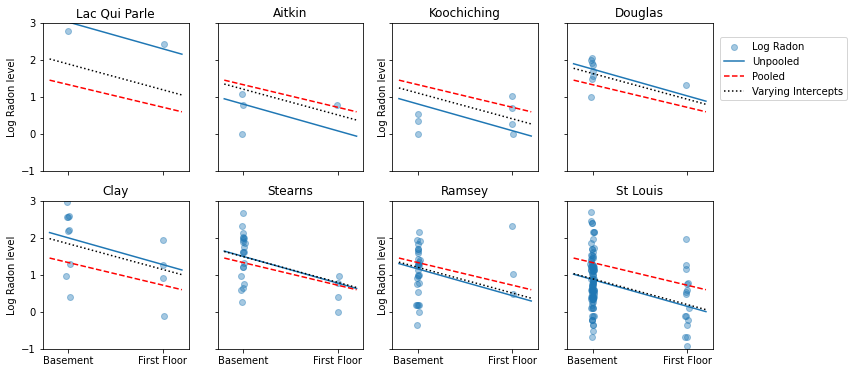

In [79]:
varying_intercepts_estimates = LinearEstimates(
    sample_mean(varying_intercepts_samples.a),
    sample_mean(varying_intercepts_samples.b))
sample_counties = ('Lac Qui Parle', 'Aitkin', 'Koochiching', 'Douglas', 'Clay',
                   'Stearns', 'Ramsey', 'St Louis')
plot_estimates(
    linear_estimates=[
        unpooled_estimates, pooled_estimate, varying_intercepts_estimates
    ],
    labels=['Unpooled', 'Pooled', 'Varying Intercepts'],
    sample_counties=sample_counties)

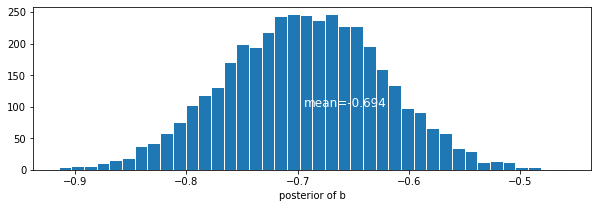

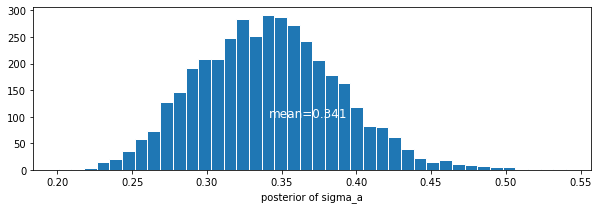

In [80]:
def plot_posterior(var_name, var_samples):
  if isinstance(var_samples, tf.Tensor):
    var_samples = var_samples.numpy() # convert to numpy array

  fig = plt.figure(figsize=(10, 3))
  ax = fig.add_subplot(111)
  ax.hist(var_samples.flatten(), bins=40, edgecolor='white')
  sample_mean = var_samples.mean()
  ax.text(
      sample_mean,
      100,
      'mean={:.3f}'.format(sample_mean),
      color='white',
      fontsize=12)
  ax.set_xlabel('posterior of ' + var_name)
  plt.show()


plot_posterior('b', varying_intercepts_samples.b)
plot_posterior('sigma_a', varying_intercepts_samples.sigma_a)

In [81]:
for var in ['b']:
  var_samples = getattr(varying_intercepts_samples, var)
  mean = var_samples.numpy().mean()
  std = var_samples.numpy().std()
  r_hat = tfp.mcmc.potential_scale_reduction(var_samples).numpy()
  n_eff = tfp.mcmc.effective_sample_size(var_samples).numpy().sum()

  print('var: ', var, ' mean: ', mean, ' std: ', std, ' n_eff: ', n_eff,
        ' r_hat: ', r_hat)

var:  b  mean:  -0.6941561  std:  0.07095849  n_eff:  637.7624  r_hat:  1.0222878


In [82]:
def plot_intercepts_and_slopes(linear_estimates, title):
  xvals = np.arange(2)
  intercepts = np.ones([num_counties]) * linear_estimates.intercept
  slopes = np.ones([num_counties]) * linear_estimates.slope
  fig, ax = plt.subplots()
  for c in range(num_counties):
    ax.plot(xvals, intercepts[c] + slopes[c] * xvals, 'bo-', alpha=0.4)
  plt.xlim(-0.2, 1.2)
  ax.set_xticks([0, 1])
  ax.set_xticklabels(['Basement', 'First Floor'])
  ax.set_ylabel('Log Radon level')
  plt.title(title)
  plt.show()

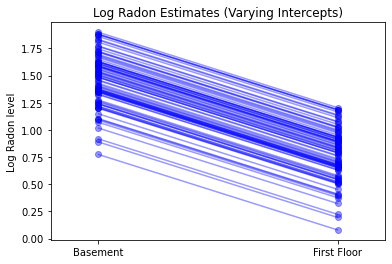

In [83]:
plot_intercepts_and_slopes(varying_intercepts_estimates,
                           'Log Radon Estimates (Varying Intercepts)')

In [84]:
def varying_slopes_model(floor, county):
  """Creates a joint distribution for the varying slopes model."""
  return tfd.JointDistributionSequential([
      tfd.Normal(loc=0., scale=1e5),  # mu_b
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_b
      tfd.Normal(loc=0., scale=1e5),  # a
      lambda _, sigma_b, mu_b: tfd.MultivariateNormalDiag(  # b
          loc=affine(tf.ones([num_counties]), mu_b[..., tf.newaxis]),
          scale_identity_multiplier=sigma_b),
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_y
      lambda sigma_y, b, a: tfd.MultivariateNormalDiag(  # y
          loc=affine(floor, tf.gather(b, county, axis=-1), a[..., tf.newaxis]),
          scale_identity_multiplier=sigma_y)
  ])


def varying_slopes_log_prob(mu_b, sigma_b, a, b, sigma_y):
  return varying_slopes_model(floor, county).log_prob(
      [mu_b, sigma_b, a, b, sigma_y, log_radon])

In [85]:
@tf.function
def sample_varying_slopes(num_chains, num_results, num_burnin_steps):
  """Samples from the varying slopes model."""
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=varying_slopes_log_prob,
      num_leapfrog_steps=25,
      step_size=0.01)

  initial_state = [
      tf.zeros([num_chains], name='init_mu_b'),
      tf.ones([num_chains], name='init_sigma_b'),
      tf.zeros([num_chains], name='init_a'),
      tf.zeros([num_chains, num_counties], name='init_b'),
      tf.ones([num_chains], name='init_sigma_y')
  ]
  unconstraining_bijectors = [
      tfb.Identity(),  # mu_b
      tfb.Exp(),       # sigma_b
      tfb.Identity(),  # a
      tfb.Identity(),  # b
      tfb.Exp()        # sigma_y
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [86]:
VaryingSlopesModel = collections.namedtuple(
    'VaryingSlopesModel', ['mu_b', 'sigma_b', 'a', 'b', 'sigma_y'])

samples, acceptance_probs = sample_varying_slopes(
    num_chains=4, num_results=1000, num_burnin_steps=1000)

print('Acceptance Probabilities: ', acceptance_probs.numpy())
varying_slopes_samples = VaryingSlopesModel._make(samples)

Acceptance Probabilities:  [0.983 0.978 0.99  0.983]


In [87]:
for var in ['mu_b', 'sigma_b', 'a', 'sigma_y']:
  print(
      'R-hat for ', var, '\t: ',
      tfp.mcmc.potential_scale_reduction(getattr(varying_slopes_samples,
                                                 var)).numpy())

R-hat for  mu_b 	:  1.0779825
R-hat for  sigma_b 	:  1.0893111
R-hat for  a 	:  1.0043279
R-hat for  sigma_y 	:  0.99963593


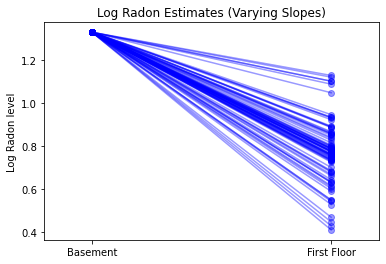

In [88]:
varying_slopes_estimates = LinearEstimates(
    sample_mean(varying_slopes_samples.a),
    sample_mean(varying_slopes_samples.b))

plot_intercepts_and_slopes(varying_slopes_estimates,
                           'Log Radon Estimates (Varying Slopes)')

In [89]:
def varying_intercepts_and_slopes_model(floor, county):
  """Creates a joint distribution for the varying slope model."""
  return tfd.JointDistributionSequential([
      tfd.Normal(loc=0., scale=1e5),    # mu_a
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_a
      tfd.Normal(loc=0., scale=1e5),    # mu_b
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_b
      lambda sigma_b, mu_b, sigma_a, mu_a: tfd.MultivariateNormalDiag(  # a
          loc=affine(tf.ones([num_counties]), mu_a[..., tf.newaxis]),
          scale_identity_multiplier=sigma_a),
      lambda _, sigma_b, mu_b: tfd.MultivariateNormalDiag(  # b
          loc=affine(tf.ones([num_counties]), mu_b[..., tf.newaxis]),
          scale_identity_multiplier=sigma_b),
      tfd.HalfCauchy(loc=0., scale=5),  # sigma_y
      lambda sigma_y, b, a: tfd.MultivariateNormalDiag(  # y
          loc=affine(floor, tf.gather(b, county, axis=-1),
                     tf.gather(a, county, axis=-1)),
          scale_identity_multiplier=sigma_y)
  ])


@tf.function
def varying_intercepts_and_slopes_log_prob(mu_a, sigma_a, mu_b, sigma_b, a, b,
                                           sigma_y):
  """Computes joint log prob pinned at `log_radon`."""
  return varying_intercepts_and_slopes_model(floor, county).log_prob(
      [mu_a, sigma_a, mu_b, sigma_b, a, b, sigma_y, log_radon])

In [90]:
@tf.function
def sample_varying_intercepts_and_slopes(num_chains, num_results,
                                         num_burnin_steps):
  """Samples from the varying intercepts and slopes model."""
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=varying_intercepts_and_slopes_log_prob,
      num_leapfrog_steps=50,
      step_size=0.01)

  initial_state = [
      tf.zeros([num_chains], name='init_mu_a'),
      tf.ones([num_chains], name='init_sigma_a'),
      tf.zeros([num_chains], name='init_mu_b'),
      tf.ones([num_chains], name='init_sigma_b'),
      tf.zeros([num_chains, num_counties], name='init_a'),
      tf.zeros([num_chains, num_counties], name='init_b'),
      tf.ones([num_chains], name='init_sigma_y')
  ]
  unconstraining_bijectors = [
      tfb.Identity(),  # mu_a
      tfb.Exp(),       # sigma_a
      tfb.Identity(),  # mu_b
      tfb.Exp(),       # sigma_b
      tfb.Identity(),  # a
      tfb.Identity(),  # b
      tfb.Exp()        # sigma_y
  ]
  kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstraining_bijectors)
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=kernel)

  acceptance_probs = tf.reduce_mean(
      tf.cast(kernel_results.inner_results.is_accepted, tf.float32), axis=0)

  return samples, acceptance_probs

In [91]:
VaryingInterceptsAndSlopesModel = collections.namedtuple(
    'VaryingInterceptsAndSlopesModel',
    ['mu_a', 'sigma_a', 'mu_b', 'sigma_b', 'a', 'b', 'sigma_y'])

samples, acceptance_probs = sample_varying_intercepts_and_slopes(
    num_chains=4, num_results=1000, num_burnin_steps=500)

print('Acceptance Probabilities: ', acceptance_probs.numpy())
varying_intercepts_and_slopes_samples = VaryingInterceptsAndSlopesModel._make(
    samples)

Acceptance Probabilities:  [0.98  0.987 0.986 0.988]


In [92]:
for var in ['mu_a', 'sigma_a', 'mu_b', 'sigma_b']:
  print(
      'R-hat for ', var, '\t: ',
      tfp.mcmc.potential_scale_reduction(
          getattr(varying_intercepts_and_slopes_samples, var)).numpy())

R-hat for  mu_a 	:  0.9990387
R-hat for  sigma_a 	:  1.0037036
R-hat for  mu_b 	:  1.0166523
R-hat for  sigma_b 	:  1.1086576


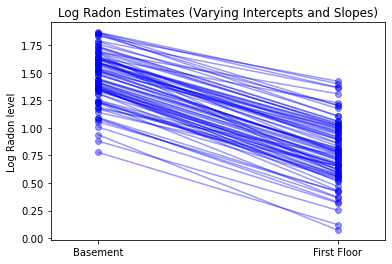

In [93]:
varying_intercepts_and_slopes_estimates = LinearEstimates(
    sample_mean(varying_intercepts_and_slopes_samples.a),
    sample_mean(varying_intercepts_and_slopes_samples.b))

plot_intercepts_and_slopes(
    varying_intercepts_and_slopes_estimates,
    'Log Radon Estimates (Varying Intercepts and Slopes)')

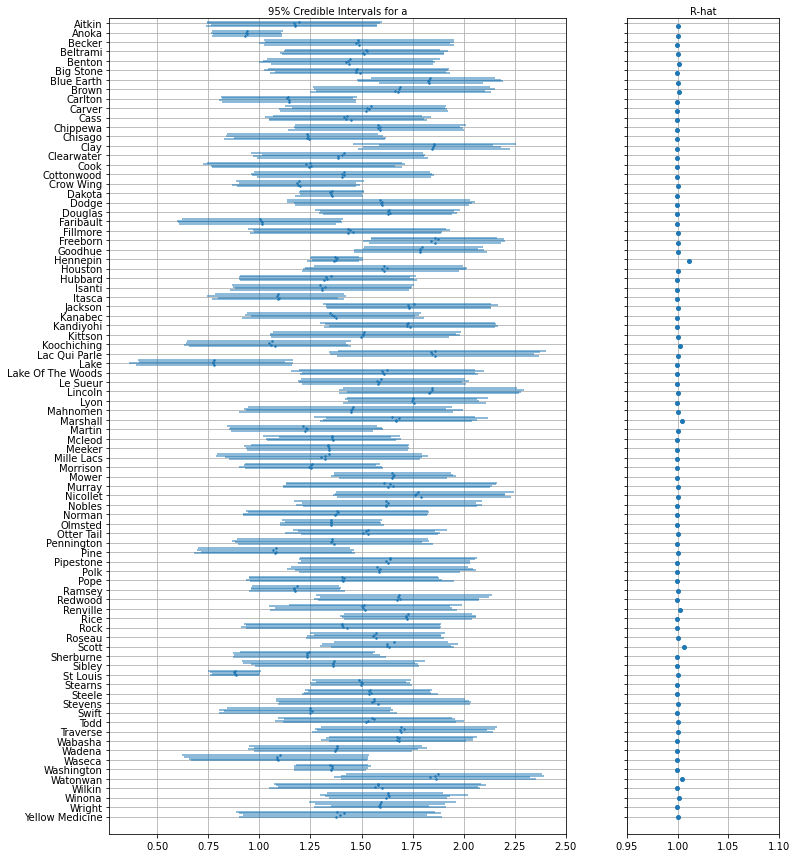

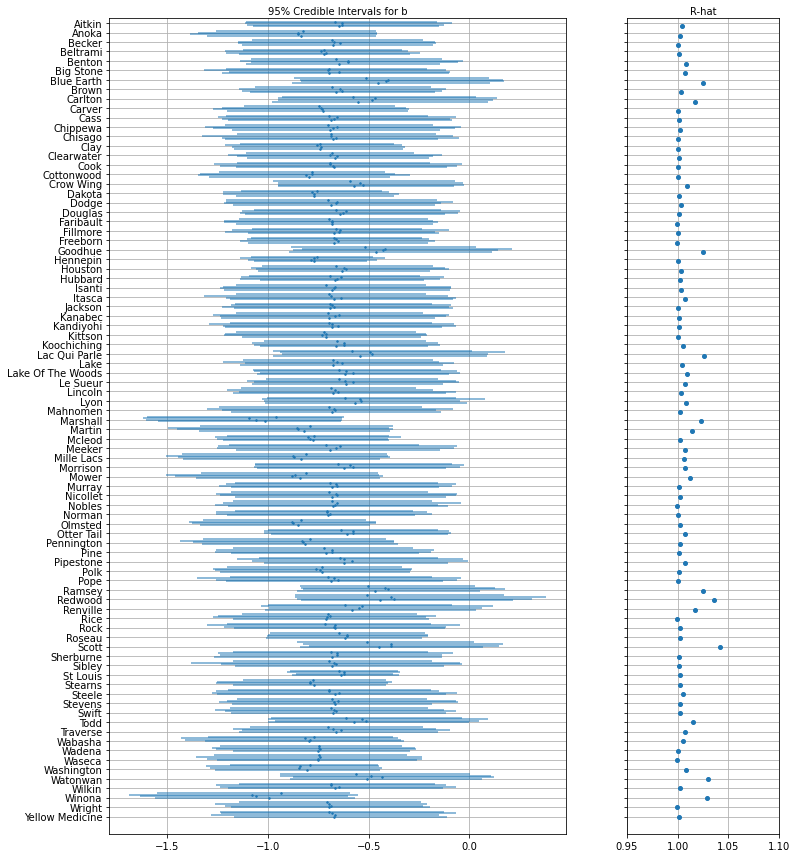

In [94]:
forest_plot(
    num_chains=4,
    num_vars=num_counties,
    var_name='a',
    var_labels=county_name,
    samples=varying_intercepts_and_slopes_samples.a.numpy())
forest_plot(
    num_chains=4,
    num_vars=num_counties,
    var_name='b',
    var_labels=county_name,
    samples=varying_intercepts_and_slopes_samples.b.numpy())